<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tensorflow-卷据神经网络实战" data-toc-modified-id="Tensorflow-卷据神经网络实战-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tensorflow 卷据神经网络实战</a></span></li></ul></div>

# Tensorflow 卷据神经网络实战

In [1]:
# 导入相关的库
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import h5py
import math 
from tensorflow.python.framework import ops 

import cnn_utils
import tf_utils

%matplotlib inline 
np.random.seed(1)

In [2]:
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = tf_utils.load_dataset()

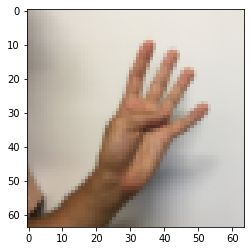

In [3]:
# 查看数据
index = 5
plt.imshow(X_train_orig[index])

In [4]:
# 处理数据
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = cnn_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = cnn_utils.convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    x = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    y = tf.placeholder(tf.float32, [None, n_y])
    
    return x, y

In [6]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable('W1', 
                         [4, 4, 3, 8], 
                        initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2',
                        [2, 2, 8, 16],
                        initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {
        "W1" : W1,
        "W2" : W2
    }
    
    return parameters

In [7]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # 卷积层
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding="SAME")
    # 激活
    A1 = tf.nn.relu(Z1)
    # 池化层
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    
    P = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P, 6, activation_fn=None)
    
    return Z3

In [8]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    
    return cost

In [9]:
tf.reset_default_graph()

with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    
    init = tf.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(cost,{X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))
    
    sess_test.close()



Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

cost = 4.6648693


In [10]:
def compute_cost(Z3,Y):
    """
    计算成本
    参数：
        Z3 - 正向传播最后一个LINEAR节点的输出，维度为（6，样本数）。
        Y - 标签向量的placeholder，和Z3的维度相同
    
    返回：
        cost - 计算后的成本
    
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    
    return cost


In [11]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, 
         num_epochs=100,minibatch_size=64,print_cost=True,isPlot=True):
    """
    使用TensorFlow实现三层的卷积神经网络
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    参数：
        X_train - 训练数据，维度为(None, 64, 64, 3)
        Y_train - 训练数据对应的标签，维度为(None, n_y = 6)
        X_test - 测试数据，维度为(None, 64, 64, 3)
        Y_test - 训练数据对应的标签，维度为(None, n_y = 6)
        learning_rate - 学习率
        num_epochs - 遍历整个数据集的次数
        minibatch_size - 每个小批量数据块的大小
        print_cost - 是否打印成本值，每遍历100次整个数据集打印一次
        isPlot - 是否绘制图谱
        
    返回：
        train_accuracy - 实数，训练集的准确度
        test_accuracy - 实数，测试集的准确度
        parameters - 学习后的参数
    """
    ops.reset_default_graph()  #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)    #确保你的数据和我一样
    seed = 3                 #指定numpy的随机种子
    (m , n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    #为当前维度创建占位符
    X , Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    #初始化参数
    parameters = initialize_parameters()
    
    #前向传播
    Z3 = forward_propagation(X,parameters)
    
    #计算成本
    cost = compute_cost(Z3,Y)
    
    #反向传播，由于框架已经实现了反向传播，我们只需要选择一个优化器就行了
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #全局初始化所有变量
    init = tf.global_variables_initializer()
    
    #开始运行
    with tf.Session() as sess:
        #初始化参数
        sess.run(init)
        #开始遍历数据集
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size) #获取数据块的数量
            seed = seed + 1
            minibatches = cnn_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed) 
            
            #对每个数据块进行处理
            for minibatch in minibatches:
                #选择一个数据块
                (minibatch_X,minibatch_Y) = minibatch
                #最小化这个数据块的成本
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                #累加数据块的成本值
                minibatch_cost += temp_cost / num_minibatches
    
            #是否打印成本
            if print_cost:
                #每5代打印一次
                if epoch % 5 == 0:
                    print("当前是第 " + str(epoch) + " 代，成本值为：" + str(minibatch_cost))
            
            #记录成本
            if epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        #数据处理完毕，绘制成本曲线
        if isPlot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
        
        #开始预测数据
        ## 计算当前的预测情况
        predict_op = tf.arg_max(Z3,1)
        corrent_prediction = tf.equal(predict_op , tf.arg_max(Y,1))
        
        ##计算准确度
        accuracy = tf.reduce_mean(tf.cast(corrent_prediction,"float"))
        print("corrent_prediction accuracy= " + str(accuracy))
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuary = accuracy.eval({X: X_test, Y: Y_test})
        
        print("训练集准确度：" + str(train_accuracy))
        print("测试集准确度：" + str(test_accuary))
        
        return (train_accuracy,test_accuary,parameters)


当前是第 0 代，成本值为：1.9213323593139648
当前是第 5 代，成本值为：1.9041557535529137
当前是第 10 代，成本值为：1.904308833181858
当前是第 15 代，成本值为：1.904477171599865
当前是第 20 代，成本值为：1.901875652372837
当前是第 25 代，成本值为：1.7840776294469833
当前是第 30 代，成本值为：1.6810505613684654
当前是第 35 代，成本值为：1.618206426501274
当前是第 40 代，成本值为：1.5979710295796394
当前是第 45 代，成本值为：1.5667064636945724


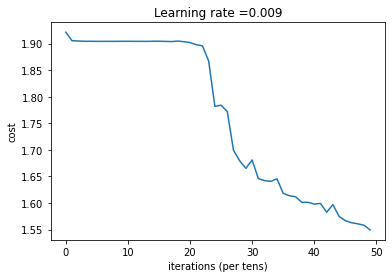

Instructions for updating:
Use `argmax` instead
corrent_prediction accuracy= Tensor("Mean_1:0", shape=(), dtype=float32)
训练集准确度：0.36851853
测试集准确度：0.35


In [12]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=50)